<a href="https://colab.research.google.com/github/JRamon19/CUDA_LABS/blob/main/ECU3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Funciona correctamente con la version 2025.10

# LIBRARY
!uv pip install -q --system numba-cuda==0.4.0
!pip install pynvjitlink-cu12

import numpy as np
from numba import cuda
import time
import os
from numba import config
import numba
config.CUDA_ENABLE_PYNVJITLINK=1

In [2]:
# EXAMPLE 1: VECTOR ADDITION
import numpy as np
from numba import cuda
import math
import time

@numba.cuda.jit
def vector_add_kernel(a, b, c):
  """
  Cada hilo calcula un elemento: c[i] = a[i] + b[i]
  """

  #Calcula el índice del subproceso global
  idx = cuda.grid(1)

  # Comprobación de límites
  # Operacion Lineal
  if idx < c.size:
    c[idx] = a[idx] + b[idx]

def main():
  N_large = 10_000_000
  a = np.random.randn(N_large).astype(np.float32)
  b = np.random.randn(N_large).astype(np.float32)
  c = np.zeros(N_large, dtype=np.float32)

  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  treads_per_block = 256
  blocks_per_grid = math.ceil(N_large / treads_per_block)

  # Warrup "Significa calentar el Chip de la GPU"
  vector_add_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  vector_add_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_c.copy_to_host()

  #GPU timing
  cpu_start = time.time()
  expected = a + b
  cpu_time = (time.time() - cpu_start) * 1000

  #Warrup
  vector_add_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  #GPU timing
  start = time.time()
  vector_add_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_c.copy_to_host()

  #GPU timing
  cpu_start = time.time()
  expected = a + b
  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print(f"Correct:" , np.allclose(result , expected))

if __name__ == "__main__":
  main()

GPU kernel time: 0.551 ms
CPU NumPy time: 15.791 ms
Speedup: 28.67x
Correct: True


In [3]:
# EXAMPLE 2: VECTOR ADDITION WITH LESS ELEMENTS
import numpy as np
from numba import cuda
import math
import time

@numba.cuda.jit
def dummy_compute_kernel(a, b, c):
  """
  Cálculo sencillo para medir el tiempo: c[i] = sqrt(a[i]^2 + b[i]^2)
  """
  idx = cuda.grid(1)
  if idx < c.size:
    c[idx] = math.sqrt(a[idx] ** 2 + b[idx] ** 2)

def main():
  N = 1_000_000 #1M elements
  a = np.random.randn(N).astype(np.float32)
  b = np.random.randn(N).astype(np.float32)
  c = np.zeros(N, dtype=np.float32)

  # Device arrays
  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  treads_per_block = 256
  blocks_per_grid = math.ceil( N / treads_per_block)

  # Warrup "Significa calentar el Chip de la GPU"
  dummy_compute_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  # Timed run
  start = time.time()
  dummy_compute_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize() # IMPORTANT: wait for kernel to finish
  end = time.time()

  gpu_time = (end - start) * 1000 # Convert to ms

  result = d_c.copy_to_host()

  # Warrup "Significa calentar el Chip de la GPU"
  dummy_compute_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  # Timed run
  start = time.time()
  dummy_compute_kernel[blocks_per_grid, treads_per_block](d_a, d_b, d_c)
  cuda.synchronize() # IMPORTANT: wait for kernel to finish
  end = time.time()

  gpu_time = (end - start) * 1000 # Lo convierte a ms

  result = d_c.copy_to_host()

  #CPU reference
  cpu_start = time.time()
  expected = np.sqrt(a ** 2 + b ** 2)
  cpu_end = time.time()
  cpu_time = (cpu_end - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print(f"Correct:" , np.allclose(result , expected))

if __name__ == "__main__":
  main()

GPU kernel time: 0.151 ms
CPU NumPy time: 4.782 ms
Speedup: 31.64x
Correct: True


In [4]:
# EXAMPLE 3: OPERATIONS WITH SCALARS
import numpy as np
from numba import cuda
import math
import time

# Nvidia profiler
@numba.cuda.jit
def matrix_scale_kernel(mat, scalar, out):
  """
  Scale every element: out[row,col] = mat[row,col] * scalar
  """
  row, col = cuda.grid(2)
  if row < out.shape[0] and col < out.shape[1]:
    out[row, col] = mat[row, col] * scalar

def main():
  rows_large, cols_large = 4096, 4096
  mat = np.random.randn(rows_large, cols_large).astype(np.float32)
  out = np.zeros_like(mat)
  scalar = 2.5
  d_mat = cuda.to_device(mat)
  d_out = cuda.to_device(out)
  threads_per_block = (32, 32)
  blocks_per_grid_x = math.ceil(rows_large / threads_per_block[0])
  blocks_per_grid_y = math.ceil(cols_large / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Warmup (El primer lanzamiento puede ser más lento debido a la compilación JIT)
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize() # Important: wait for kernel to finish
  end = time.time()
  gpu_time = (end - start) * 1000 # convert to ms
  result = d_out.copy_to_host()

  # CPU timing
  cpu_start = time.time()
  expected = mat * scalar
  cpu_end = time.time()
  cpu_time = (cpu_end - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"SpeedUp: {cpu_time / gpu_time:.2f}x")
  print(f"Correct: ", np.allclose(result, expected))

if __name__ == "__main__":
  main()

GPU kernel time: 4.200 ms
CPU NumPy time: 20.983 ms
SpeedUp: 5.00x
Correct:  True


In [5]:
# EXAMPLE 4: MATRIX MULTIPLICATION
import numpy as np
import numba.cuda as cuda
import math
import time

@numba.cuda.jit
def matrix_multiply_kernel(A, B, C):

  """
Multiplicación de matrices simple: C = A @ B
Cada hilo calcula un elemento de C.
Todas las lecturas de A y B se almacenan en la memoria global (lenta).
Modificación: memoria compartida.

  A: (M, K)
  B: (k, N)
  C: (M, N)
  """

  row, col = cuda.grid(2)

  M, K = A.shape
  K, N = B.shape

  if row < M and col < N:
    total = 0.0
    for k in range(K):
      total += A[row, k] * B[k, col]
      C[row, col] = total

def main():
  M, K, N = 1000, 1000, 1000
  A = np.random.randn(M, K).astype(np.float32)
  B = np.random.randn(K, N).astype(np.float32)
  C = np.zeros((M, N), dtype=np.float32)

  treads_per_block = (32, 32)
  d_A = cuda.to_device(A)
  d_B = cuda.to_device(B)
  d_C = cuda.to_device(C)

  blocks_per_grid_x = (M + treads_per_block[0] - 1) // treads_per_block[0]
  blocks_per_grid_y = (N + treads_per_block[1] - 1) // treads_per_block[1]
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Warrup
  matrix_multiply_kernel[blocks_per_grid, treads_per_block](d_A, d_B, d_C)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  matrix_multiply_kernel[blocks_per_grid, treads_per_block](d_A, d_B, d_C)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  C_gpu = d_C.copy_to_host()

    # Warrup
  matrix_multiply_kernel[blocks_per_grid, treads_per_block](d_A, d_B, d_C)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  matrix_multiply_kernel[blocks_per_grid, treads_per_block](d_A, d_B, d_C)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  C_gpu = d_C.copy_to_host()

  # CPU timing
  cpu_start = time.time()
  C_cpu = A @ B
  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.4f} ms")
  print(f"CPU NumPy time: {cpu_time:.4f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print(f"Correct: , {np.allclose(C_gpu, C_cpu, atol = 1e-3)}")

if __name__ == "__main__":
  main()

GPU kernel time: 72.8357 ms
CPU NumPy time: 58.3858 ms
Speedup: 0.80x
Correct: , True


Image: 2160x3848 (8,311,680 pixels)
Grid: (241, 135) blocks x (32, 32) threads

Results
GPU: 24.26 ms
CPU: 150.59 ms
Speedup: 6.2x
Correct: False


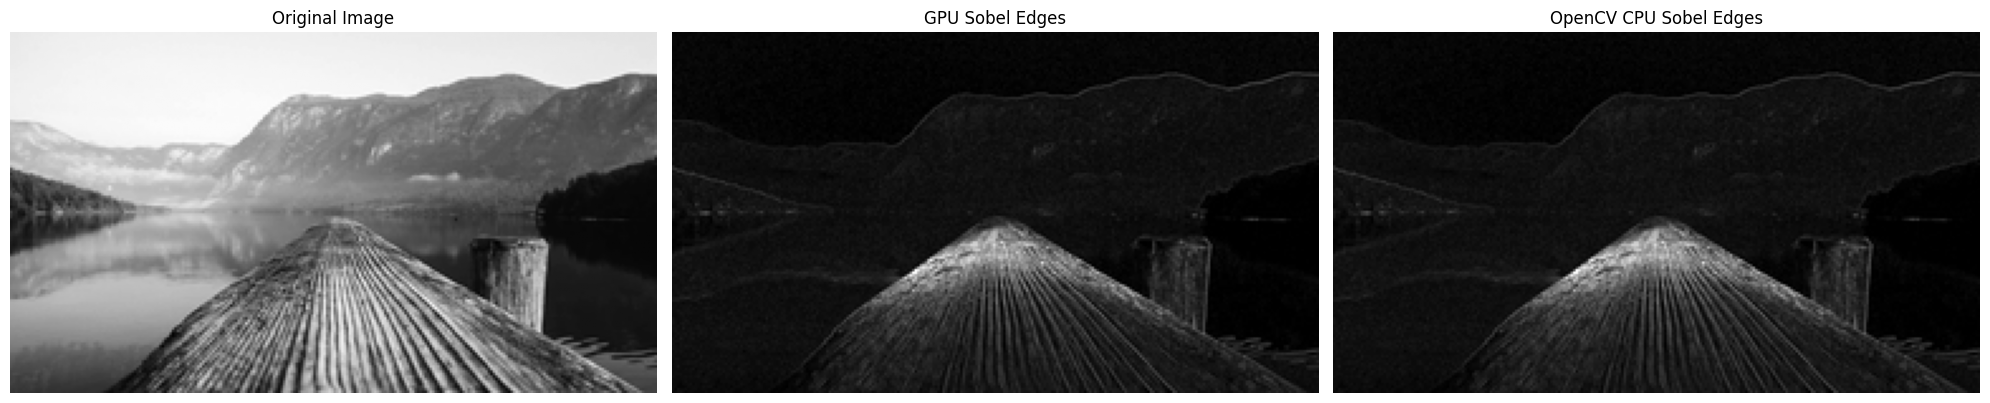

In [6]:
# EXAMPLE 5: IMAGE PROCESSOR

import numpy as np
import numba.cuda as cuda
import time
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import cv2

@numba.cuda.jit
def sobel_kernel(img, out):
  # Aplicar detección de bordes Sobel: cada hilo procesa un píxel
  row, col = cuda.grid(2)
  H, W = img.shape

  if 0 < row < H - 1 and 0 < col < W - 1:
    # Horizontal gradient (Gx)
    gx = (-img[row-1,col-1] + img[row-1,col+1] +
          -2*img[row,col-1] + 2*img[row,col+1] +
          -img[row+1,col-1] + img[row+1,col+1])

    # Vertical gradient (Gy)
    gy = (-img[row-1,col-1] - 2*img[row-1,col] - img[row-1,col+1] +
          img[row+1,col-1] + 2*img[row+1,col] + img[row+1,col+1])

    # Magnitud de la ventana
    out[row, col] = (gx*gx + gy*gy)**0.5

def sobel_opencv(img):
  # Abrir CV CPU version usando Sobel
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
  return np.sqrt(gx**2 + gy**2)

# Cargar una imagen 4k de la web
urllib.request.urlretrieve("https://picsum.photos/3848/2160","image.jpg")
img = Image.open("image.jpg").convert("L")
img = np.asarray(img, dtype=np.float32)

H, W = img.shape
print(f"Image: {H}x{W} ({W*H:,} pixels)")

d_img = cuda.to_device(img)
d_out = cuda.to_device(np.zeros_like(img))

threads = (32, 32)
blocks = ((W + 15) // 16, (H + 15) // 16)

print(f"Grid: {blocks} blocks x {threads} threads")

# Warmup
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize()

# Time run
start = time.time()
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize()
gpu_time = (time.time() - start) * 1000

out_gpu = d_out.copy_to_host()

# Time CPU
start = time.time()
out_cpu = sobel_opencv(img)
cpu_time = (time.time() - start) * 1000

# Resultados
print("\n" + "="*60)
print("Results")
print("="*60)
print(f"GPU: {gpu_time:.2f} ms")
print(f"CPU: {cpu_time:.2f} ms")
print(f"Speedup: {cpu_time / gpu_time:.1f}x")
print(f"Correct: {np.allclose(out_gpu, out_cpu, atol=1e-3)}")

# Ajustar el tamaño de la imagen
H, W = img.shape
target_w = 256
target_h = int(target_w * H / W)

def resize_for_plot(array):
    normalized = (array / array.max() * 255).astype(np.uint8)
    return np.array(Image.fromarray(normalized).resize((target_w, target_h), Image.LANCZOS))

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(resize_for_plot(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resize_for_plot(out_gpu), cmap='gray')
plt.title('GPU Sobel Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(resize_for_plot(out_cpu), cmap='gray')
plt.title('OpenCV CPU Sobel Edges')
plt.axis('off')

plt.tight_layout()
plt.show()